In [1]:
#| default_exp quant_reader

In [2]:
#| export
import os
import pathlib
if "__file__" in globals():#only run in the translated python file, as __file__ is not defined with ipython
    INTABLE_CONFIG = os.path.join(pathlib.Path(__file__).parent.absolute(), "../alphabase/constants/const_files/intable_config.yaml") #the yaml config is located one directory below the python library files

# Utility Functions

## Reformatting and transformation functions

In [3]:
#| export
def invert_dictionary(my_map):
    inv_map = {}
    for k, v in my_map.items():
        inv_map[v] = inv_map.get(v, []) + [k]
    return inv_map

In [4]:
#| export

def add_mq_protein_group_ids_if_applicable_and_obtain_annotated_file(mq_file, input_type_to_use ,mq_protein_group_file, columns_to_add):
    try:
        input_type = _get_input_type(mq_file, input_type_to_use)
        if ("maxquant_evidence" in input_type or "maxquant_peptides" in input_type) and ("aq_reformat" not in mq_file):
            if mq_protein_group_file is None:
                print("You provided a MaxQuant peptide or evidence file as input. To have the identical ProteinGroups as in the MaxQuant analysis, please provide the ProteinGroups.txt file as well.")
                return mq_file
            else:
                mq_df = load_input_file_and_de_duplicate_if_evidence(mq_file, input_type, columns_to_add)
                id_column = determine_id_column_from_input_df(mq_df)
                id2protein_df = create_id_to_protein_df(mq_protein_group_file, id_column)
                annotated_mq_df = annotate_mq_df(mq_df, id2protein_df, id_column)
                annotated_mq_filename = f"{mq_file}.protgroup_annotated.tsv"
                save_annotated_mq_df(annotated_mq_df, annotated_mq_filename)
                return annotated_mq_filename
        else:
            return mq_file
    except:
        return mq_file


def _get_input_type(mq_file ,input_type_to_use):
    if input_type_to_use is not None:
        return input_type_to_use
    else:
        return get_input_type_and_config_dict(mq_file)[0]
    

def load_input_file_and_de_duplicate_if_evidence(input_file, input_type, columns_to_add):
    input_df = pd.read_csv(input_file, sep = "\t")
    if "maxquant_evidence" in input_type:
        subset_columns = ['id','Sequence','Modified sequence', 'Experiment','Charge', 'Raw file', 'Gene names', 'Intensity', 'Reverse', 'Potential contaminant'] + columns_to_add
        columns_to_group_by = ['Sequence','Modified sequence', 'Experiment','Charge', 'Raw file']
        input_df = input_df[subset_columns].set_index(columns_to_group_by)
        input_df_grouped = input_df.groupby(columns_to_group_by).Intensity.max()
        input_df_no_intensities = input_df.drop(columns=["Intensity"])

        input_df = input_df_no_intensities.merge(input_df_grouped, how= 'right', left_index=True, right_index=True).reset_index()
        input_df = input_df.drop_duplicates(subset=columns_to_group_by)

    return input_df

def create_id_to_protein_df(mq_protein_group_file, id_column):    
    id_mapping_df = pd.read_csv(mq_protein_group_file, sep = "\t", usecols=["Protein IDs", id_column])
    #apply lambda function to id column to split it into a list of ids
    id_mapping_df[id_column] = id_mapping_df[id_column].apply(lambda x: x.split(";"))
    #explode the id column
    id_mapping_df = id_mapping_df.explode(id_column) #https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
    return id_mapping_df


def determine_id_column_from_input_df(input_df):
    input_file_columns = input_df.columns
    num_cols_starting_w_intensity = sum([x.startswith("Intensity ") for x in input_file_columns])
    if num_cols_starting_w_intensity>0:
        return "Peptide IDs"
    else:
        return "Evidence IDs"


def annotate_mq_df(mq_df, id2protein_df, id_column):
    #set dtype of id to string
    mq_df["id"] = mq_df["id"].astype(str)
    id2protein_df = remove_ids_not_occurring_in_mq_df(id2protein_df, mq_df, id_column)
    return mq_df.merge(id2protein_df, how = "right",  left_on = "id", right_on = id_column, suffixes=('', '_y'))

def remove_ids_not_occurring_in_mq_df(id2protein_df, mq_df, id_column):
    mq_df_ids = set(mq_df["id"])
    id2protein_df = id2protein_df[id2protein_df[id_column].isin(mq_df_ids)]
    return id2protein_df

def save_annotated_mq_df(annotated_mq_df, annotated_mq_file):
    annotated_mq_df.to_csv(annotated_mq_file, sep = "\t", index = False)



In [5]:
#| export
from distutils.command.config import config


def add_columns_to_lfq_results_table(lfq_results_df, input_file, columns_to_add):
    input_type, config_dict, _ = get_input_type_and_config_dict(input_file)

    input_file = clean_input_filename_if_necessary(input_file)

    protein_column_input_table = get_protein_column_input_table(config_dict)
    standard_columns_for_input_type = get_standard_columns_for_input_type(input_type)

    all_columns = columns_to_add + [protein_column_input_table] + standard_columns_for_input_type
    all_columns = filter_columns_to_existing_columns(all_columns, input_file)

    input_df = pd.read_csv(input_file, sep="\t", usecols=all_columns).drop_duplicates(subset=protein_column_input_table)
    lfq_results_df = lfq_results_df[[x is not None for x in lfq_results_df['protein']]]

    length_before = len(lfq_results_df.index)
    lfq_results_df_appended = pd.merge(lfq_results_df, input_df, left_on='protein', right_on=protein_column_input_table, how='left')
    length_after = len(lfq_results_df_appended.index)

    lfq_results_df_appended = lfq_results_df_appended.set_index('protein')
    

    assert length_before == length_after
    return lfq_results_df_appended

def clean_input_filename_if_necessary(input_file):
    if "aq_reformat.tsv" in input_file:
        input_file = get_original_file_from_aq_reformat(input_file)
    return input_file

def get_protein_column_input_table(config_dict):
    return config_dict["protein_cols"][0]

def get_standard_columns_for_input_type(input_type):
    
    if 'maxquant' in input_type:
        return ["Gene names"]
    elif 'diann' in input_type:
        return ["Protein.Names", "Genes"]
    elif 'spectronaut' in input_type:
        return ['PG.Genes']
    else:
        return []

def filter_columns_to_existing_columns(columns, input_file):
    existing_columns =  pd.read_csv(input_file, sep='\t', nrows=1).columns
    return [x for x in columns if x in existing_columns]



#function that shows the differing rows between two dataframes
def show_diff(df1, df2):
    return df1.merge(df2, indicator=True, how='outer').loc[lambda x : x['_merge']!='both']


## I/O functions

In [6]:
#| export
def write_chunk_to_file(chunk, filepath ,write_header):
    """write chunk of pandas dataframe to a file"""
    chunk.to_csv(filepath, header=write_header, mode='a', sep = "\t", index = None)

In [7]:
#| export
import numpy as np
def index_and_log_transform_input_df(data_df):
    data_df = data_df.set_index(["protein", "ion"])
    return np.log2(data_df.replace(0, np.nan))

In [8]:
#| export
def remove_allnan_rows_input_df(data_df):
    return data_df.dropna(axis = 0, how = 'all')


    

# Input Parsers
The directlfq pipeline is run using a generic wide-table input format, as specified in the documentation. The following parsers convert long format tables as provided e.g. by Spectronaut or DIA-NN into this generic format. The configuration for the parsers is set by a yaml file.

## Convert long format to wide format

### Parse .yaml file
The relevant parameters for reading and reformatting the long table are stored in the "intable_config.yaml" file. The functions below are for reading and reformating the config info

In [9]:
#| export
import yaml
import itertools

def get_relevant_columns(protein_cols, ion_cols, sample_ID, quant_ID, filter_dict):
    filtcols = []
    for filtconf in filter_dict.values():
        filtcols.append(filtconf.get('param'))
    relevant_cols = protein_cols + ion_cols + [sample_ID] + [quant_ID] + filtcols
    relevant_cols = list(set(relevant_cols)) # to remove possible redudancies
    return relevant_cols


def get_relevant_columns_config_dict(config_typedict):
    filtcols = []
    dict_ioncols = []
    for filtconf in config_typedict.get('filters', {}).values():
        filtcols.append(filtconf.get('param'))

    if 'ion_hierarchy' in config_typedict.keys():
        for headr in config_typedict.get('ion_hierarchy').values():
            ioncols = list(itertools.chain.from_iterable(headr.get("mapping").values()))
            dict_ioncols.extend(ioncols)

    quant_ids = get_quant_ids_from_config_dict(config_typedict)
    sample_ids = get_sample_ids_from_config_dict(config_typedict)
    channel_ids = get_channel_ids_from_config_dict(config_typedict)
    relevant_cols = config_typedict.get("protein_cols") + config_typedict.get("ion_cols", []) + sample_ids + quant_ids + filtcols + dict_ioncols + channel_ids
    relevant_cols = list(set(relevant_cols)) # to remove possible redudancies
    return relevant_cols

def get_quant_ids_from_config_dict(config_typedict):
    quantID = config_typedict.get("quant_ID")
    if type(quantID) ==type("string"):
        return [config_typedict.get("quant_ID")]
    if quantID == None:
        return[]
    else:
        return list(config_typedict.get("quant_ID").values())

def get_sample_ids_from_config_dict(config_typedict):
    sampleID = config_typedict.get("sample_ID")
    if type(sampleID) ==type("string"):
        return [config_typedict.get("sample_ID")]
    if sampleID == None:
        return []
    else:
        return config_typedict.get("sample_ID")

def get_channel_ids_from_config_dict(config_typedict):
    return config_typedict.get("channel_ID", [])



def load_config(config_yaml):
    with open(config_yaml, 'r') as stream:
        config_all = yaml.safe_load(stream)
    return config_all

def get_type2relevant_cols(config_all):
    type2relcols = {}
    for type in config_all.keys():
        config_typedict = config_all.get(type)
        relevant_cols = get_relevant_columns_config_dict(config_typedict)
        type2relcols[type] = relevant_cols
    return type2relcols

### Filter and reformat

In [10]:
#| export

def filter_input(filter_dict, input):
    if filter_dict == None:
        return input
    for filtname,filterconf in filter_dict.items():
        param = filterconf.get('param')
        comparator = filterconf.get('comparator')
        value = filterconf.get('value')

        if comparator not in [">",">=", "<", "<=", "==", "!="]:
            raise TypeError(f"cannot identify the filter comparator of {filtname} given in the longtable config yaml!")

        if comparator=="==":
            input = input[input[param] ==value]
            continue
        try:
            input = input.astype({f"{param}" : "float"})
        except:
            pass

        if comparator==">":
            input = input[input[param].astype(type(value)) >value]

        if comparator==">=":
            input = input[input[param].astype(type(value)) >=value]

        if comparator=="<":
            input = input[input[param].astype(type(value)) <value]

        if comparator=="<=":
            input = input[input[param].astype(type(value)) <=value]

        if comparator=="!=":
            input = input[input[param].astype(type(value)) !=value]

    return input

In [11]:
#| export
def merge_protein_and_ion_cols(input_df, config_dict):
    protein_cols =  config_dict.get("protein_cols")
    ion_cols = config_dict.get("ion_cols")
    input_df['protein'] = input_df.loc[:, protein_cols].astype('string').sum(axis=1)
    input_df['ion'] = input_df.loc[:, ion_cols].astype('string').sum(axis=1)
    input_df = input_df.rename(columns = {config_dict.get('quant_ID') : "quant_val"})
    return input_df

In [12]:
#| export
import copy
def merge_protein_cols_and_ion_dict(input_df, config_dict):
    """[summary]
    
    Args:
        input_df ([pandas dataframe]): longtable containing peptide intensity data
        confid_dict ([dict[String[]]]): nested dict containing the parse information. derived from yaml file

    Returns:
        pandas dataframe: longtable with newly assigned "protein" and "ion" columns
    """
    protein_cols = config_dict.get("protein_cols")
    ion_hierarchy = config_dict.get("ion_hierarchy")
    splitcol2sep = config_dict.get('split_cols')
    quant_id_dict = config_dict.get('quant_ID')

    ion_dfs = []
    input_df['protein'] = input_df.loc[:, protein_cols].astype('string').sum(axis=1)

    input_df = input_df.drop(columns = [x for x in protein_cols if x!='protein'])
    for hierarchy_type in ion_hierarchy.keys():
        df_subset = input_df.copy()
        ion_hierarchy_local = ion_hierarchy.get(hierarchy_type).get("order")
        ion_headers_merged, ion_headers_grouped = get_ionname_columns(ion_hierarchy.get(hierarchy_type).get("mapping"), ion_hierarchy_local) #ion headers merged is just a helper to select all relevant rows, ionheaders grouped contains the sets of ionstrings to be merged into a list eg [[SEQ, MOD], [CH]]
        quant_columns = get_quantitative_columns(df_subset, hierarchy_type, config_dict, ion_headers_merged)
        headers = list(set(ion_headers_merged + quant_columns + ['protein']))
        if "sample_ID" in config_dict.keys():
            headers+=[config_dict.get("sample_ID")]
        df_subset = df_subset[headers].drop_duplicates()

        if splitcol2sep is not None:
            if quant_columns[0] in splitcol2sep.keys(): #in the case that quantitative values are stored grouped in one column (e.g. msiso1,msiso2,msiso3, etc.), reformat accordingly
                df_subset = split_extend_df(df_subset, splitcol2sep)
            ion_headers_grouped = adapt_headers_on_extended_df(ion_headers_grouped, splitcol2sep)

        #df_subset = df_subset.set_index(quant_columns)

        df_subset = add_merged_ionnames(df_subset, ion_hierarchy_local, ion_headers_grouped, quant_id_dict, hierarchy_type)
        ion_dfs.append(df_subset)
    input_df = pd.concat(ion_dfs, ignore_index=True)
    return input_df


def get_quantitative_columns(input_df, hierarchy_type, config_dict, ion_headers_merged):
    naming_columns = ion_headers_merged + ['protein']
    if config_dict.get("format") == 'longtable':
        quantcol = config_dict.get("quant_ID").get(hierarchy_type)
        return [quantcol]

    if config_dict.get("format") == 'widetable':
        quantcolumn_candidates = [x for x in input_df.columns if x not in naming_columns]
        if "quant_prefix" in config_dict.keys():
            return [x for x in quantcolumn_candidates if x.startswith(config_dict.get("quant_prefix"))] # in the case that the quantitative columns have a prefix (like "Intensity " in MQ peptides.txt), only columns with the prefix are filtered
        else:
            return quantcolumn_candidates #in this case, we assume that all non-ionname/proteinname columns are quantitative columns


def get_ionname_columns(ion_dict, ion_hierarchy_local):
    ion_headers_merged = []
    ion_headers_grouped = []
    for lvl in ion_hierarchy_local:
        vals = ion_dict.get(lvl)
        ion_headers_merged.extend(vals)
        ion_headers_grouped.append(vals)
    return ion_headers_merged, ion_headers_grouped


def adapt_headers_on_extended_df(ion_headers_grouped, splitcol2sep):
    #in the case that one column has been split, we need to designate the "naming" column
    ion_headers_grouped_copy = copy.deepcopy(ion_headers_grouped)
    for vals in ion_headers_grouped_copy:
        if splitcol2sep is not None:
            for idx in range(len(vals)):
                if vals[idx] in splitcol2sep.keys():
                    vals[idx] = vals[idx] + "_idxs"
    return ion_headers_grouped_copy

def split_extend_df(input_df, splitcol2sep, value_threshold=10):
    """reformats data that is stored in a condensed way in a single column. For example isotope1_intensity;isotope2_intensity etc. in Spectronaut

    Args:
        input_df ([type]): [description]
        splitcol2sep ([type]): [description]
        value_threshold([type]): [description]

    Returns:
        Pandas Dataframe: Pandas dataframe with the condensed items expanded to long format
    """
    if splitcol2sep==None:
        return input_df

    for split_col, separator in splitcol2sep.items():
        idx_name = f"{split_col}_idxs"
        split_col_series = input_df[split_col].str.split(separator)
        input_df = input_df.drop(columns = [split_col])

        input_df[idx_name] = [list(range(len(x))) for x in split_col_series]
        exploded_input = input_df.explode(idx_name)
        exploded_split_col_series = split_col_series.explode()

        exploded_input[split_col] = exploded_split_col_series.replace('', 0) #the column with the intensities has to come after to column with the idxs

        exploded_input = exploded_input.astype({split_col: float})
        exploded_input = exploded_input[exploded_input[split_col]>value_threshold]
        #exploded_input = exploded_input.rename(columns = {'var1': split_col})
    return exploded_input



def add_merged_ionnames(df_subset, ion_hierarchy_local, ion_headers_grouped, quant_id_dict, hierarchy_type):
    """puts together the hierarchical ion names as a column in a given input dataframe"""
    all_ion_headers = list(itertools.chain.from_iterable(ion_headers_grouped))
    columns_to_index = [x for x in df_subset.columns if x not in all_ion_headers]
    df_subset = df_subset.set_index(columns_to_index)

    rows = df_subset[all_ion_headers].to_numpy()
    ions = []

    for row in rows: #iterate through dataframe
        count = 0
        ionstring = ""
        for lvl_idx in range(len(ion_hierarchy_local)):
            ionstring += f"{ion_hierarchy_local[lvl_idx]}"
            for sublvl in ion_headers_grouped[lvl_idx]:
                ionstring+= f"_{row[count]}_"
                count+=1
        ions.append(ionstring)
    df_subset['ion'] = ions
    df_subset = df_subset.reset_index()
    if quant_id_dict!= None:
        df_subset = df_subset.rename(columns = {quant_id_dict.get(hierarchy_type) : "quant_val"})
    return df_subset

In [13]:
#| export
import os.path
def reformat_and_write_longtable_according_to_config(input_file, outfile_name, config_dict_for_type, sep = "\t",decimal = ".", enforce_largefile_processing = False, chunksize =1000_000):
    """Reshape a long format proteomics results table (e.g. Spectronaut or DIA-NN) to a wide format table.
    :param file input_file: long format proteomic results table
    :param string input_type: the configuration key stored in the config file (e.g. "diann_precursor")
    """
    filesize = os.path.getsize(input_file)/(1024**3) #size in gigabyte
    file_is_large = (filesize>10 and str(input_file).endswith(".zip")) or filesize>50 or enforce_largefile_processing

    if file_is_large:
        tmpfile_large = f"{input_file}.tmp.longformat.columnfilt.tsv" #only needed when file is large
        #remove potential leftovers from previous processings
        if os.path.exists(tmpfile_large):
            os.remove(tmpfile_large)
        if os.path.exists(outfile_name):
            os.remove(outfile_name)
    
    relevant_cols = get_relevant_columns_config_dict(config_dict_for_type)
    input_df_it = pd.read_csv(input_file, sep = sep, decimal=decimal, usecols = relevant_cols, encoding ='latin1', chunksize = chunksize)
    input_df_list = []
    header = True
    for input_df_subset in input_df_it:
        input_df_subset = adapt_subtable(input_df_subset, config_dict_for_type)
        if file_is_large:
            write_chunk_to_file(input_df_subset,tmpfile_large, header)
        else:
            input_df_list.append(input_df_subset)
        header = False
        
    if file_is_large:
        process_with_dask(tmpfile_columnfilt=tmpfile_large , outfile_name = outfile_name, config_dict_for_type=config_dict_for_type)
    else:
        input_df = pd.concat(input_df_list)
        input_reshaped = reshape_input_df(input_df, config_dict_for_type)
        input_reshaped.to_csv(outfile_name, sep = "\t", index = None)
    

def adapt_subtable(input_df_subset, config_dict):
    input_df_subset = filter_input(config_dict.get("filters", {}), input_df_subset)
    if "ion_hierarchy" in config_dict.keys():
        return merge_protein_cols_and_ion_dict(input_df_subset, config_dict)
    else:
        return merge_protein_and_ion_cols(input_df_subset, config_dict)

In [14]:
#| export
import dask.dataframe as dd
import pandas as pd
import glob
import os
import shutil 

def process_with_dask(*, tmpfile_columnfilt, outfile_name, config_dict_for_type):
    df = dd.read_csv(tmpfile_columnfilt, sep = "\t")
    allcols = df[config_dict_for_type.get("sample_ID")].drop_duplicates().compute() # the columns of the output table are the sample IDs
    allcols = extend_sample_allcolumns_for_plexdia_case(allcols_samples=allcols, config_dict_for_type=config_dict_for_type)
    allcols = ['protein', 'ion'] + sorted(allcols)
    df = df.set_index('protein')
    sorted_filedir = f"{tmpfile_columnfilt}_sorted"
    df.to_csv(sorted_filedir, sep = "\t")
    #now the files are sorted and can be pivoted chunkwise (multiindex pivoting at the moment not possible in dask)
    files_dask = glob.glob(f"{sorted_filedir}/*part")
    header = True
    for file in files_dask:
        input_df = pd.read_csv(file, sep = "\t")
        if len(input_df.index) <2:
            continue
        input_reshaped = reshape_input_df(input_df, config_dict_for_type)
        input_reshaped = sort_and_add_columns(input_reshaped, allcols)
        write_chunk_to_file(input_reshaped, outfile_name, header)
        header = False
    os.remove(tmpfile_columnfilt)
    shutil.rmtree(sorted_filedir)

def reshape_input_df(input_df, config_dict):
    input_df = input_df.astype({'quant_val': 'float'})
    input_df = adapt_input_df_columns_in_case_of_plexDIA(input_df=input_df, config_dict_for_type=config_dict)
    input_reshaped = pd.pivot_table(input_df, index = ['protein', 'ion'], columns = config_dict.get("sample_ID"), values = 'quant_val', fill_value=0)

    input_reshaped = input_reshaped.reset_index()
    return input_reshaped


def sort_and_add_columns(input_reshaped, allcols):
    missing_cols = set(allcols) - set(input_reshaped.columns)
    input_reshaped[list(missing_cols)] = 0
    input_reshaped = input_reshaped[allcols]
    return input_reshaped


def extend_sample_allcolumns_for_plexdia_case(allcols_samples, config_dict_for_type):
    if is_plexDIA_table(config_dict_for_type):
        new_allcols = []
        channels = ['mTRAQ-n-0', 'mTRAQ-n-4', 'mTRAQ-n-8']
        for channel in channels:
            for sample in allcols_samples:
                new_allcols.append(merge_channel_and_sample_string(sample, channel))
        return new_allcols
    else:
        return allcols_samples

In [15]:
#| export
#PLEXDIA case

def adapt_input_df_columns_in_case_of_plexDIA(input_df,config_dict_for_type):
    if is_plexDIA_table(config_dict_for_type):
        input_df = extend_sampleID_column_for_plexDIA_case(input_df, config_dict_for_type)
        input_df = set_mtraq_reduced_ion_column_into_dataframe(input_df)
        return input_df
    else:
        return input_df


def extend_sampleID_column_for_plexDIA_case(input_df,config_dict_for_type):
    channels_per_peptide = parse_channel_from_peptide_column(input_df)
    return merge_sample_id_and_channels(input_df, channels_per_peptide, config_dict_for_type)


def set_mtraq_reduced_ion_column_into_dataframe(input_df):
    new_ions = remove_mtraq_modifications_from_ion_ids(input_df['ion'])
    input_df['ion'] = new_ions
    return input_df

def remove_mtraq_modifications_from_ion_ids(ions):
    new_ions = []
    all_mtraq_tags = ["(mTRAQ-K-0)", "(mTRAQ-K-4)", "(mTRAQ-K-8)", "(mTRAQ-n-0)", "(mTRAQ-n-4)", "(mTRAQ-n-8)"]
    for ion in ions:
        for tag in all_mtraq_tags:
            ion = ion.replace(tag, "")
        new_ions.append(ion)
    return new_ions


def is_plexDIA_table(config_dict_for_type):
    return config_dict_for_type.get('channel_ID') == ['Channel.0', 'Channel.4', 'Channel.8']


import re
def parse_channel_from_peptide_column(input_df):
    channels = []
    for pep in input_df['Modified.Sequence']:
        pattern = "(.*)(\(mTRAQ-n-.\))(.*)"
        matched = re.match(pattern, pep)
        num_appearances = pep.count("mTRAQ-n-")
        if matched and num_appearances==1:
            channels.append(matched.group(2))
        else:
            channels.append("NA")
    return channels

def merge_sample_id_and_channels(input_df, channels, config_dict_for_type):
    sample_id = config_dict_for_type.get("sample_ID")
    sample_ids = list(input_df[sample_id])
    input_df[sample_id] = [merge_channel_and_sample_string(sample_ids[idx], channels[idx]) for idx in range(len(sample_ids))]
    return input_df
            
def merge_channel_and_sample_string(sample, channel):
    return f"{sample}_{channel}"

In [16]:
#| include: false
def test_remove_remove_mtraq_modifications_from_ion_ids():
    ions = ["SEQ_IAVLLAK_MOD_(mTRAQ-n-0)IAVLLAK(mTRAQ-K-0)", "SEQ_IAVLLAK_MOD_(mTRAQ-n-0)IAVLLAK(mTRAQ-K-0)_CHARGE_1_FRGION_2_",  "SEQ_IAVLLAK_MOD_(mTRAQ-n-0)I(mTRAQ-n-0)AVL(mTRAQ-K-0)LAK(mTRAQ-K-0)_CHARGE_1_FRGION_2_"]
    new_ions = remove_mtraq_modifications_from_ion_ids(ions)
    for ion in new_ions:
        assert 'mTRAQ' not in ion
test_remove_remove_mtraq_modifications_from_ion_ids()

In [17]:
#| export
def reformat_and_write_wideformat_table(peptides_tsv, outfile_name, config_dict):
    input_df = pd.read_csv(peptides_tsv,sep="\t", encoding ='latin1')
    filter_dict = config_dict.get("filters")
    protein_cols = config_dict.get("protein_cols")
    ion_cols = config_dict.get("ion_cols")
    input_df = filter_input(filter_dict, input_df)
    #input_df = merge_protein_and_ion_cols(input_df, config_dict)
    input_df = merge_protein_cols_and_ion_dict(input_df, config_dict)
    if 'quant_prefix' in config_dict.keys():
        quant_prefix = config_dict.get('quant_prefix')
        headers = ['protein', 'ion'] + list(filter(lambda x: x.startswith(quant_prefix), input_df.columns))
        input_df = input_df[headers]
        input_df = input_df.rename(columns = lambda x : x.replace(quant_prefix, ""))

    #input_df = input_df.reset_index()
    
    input_df.to_csv(outfile_name, sep = '\t', index = None)

In [18]:

def read_mq_peptides_table(peptides_tsv, pepheader = "Sequence", protheader = "Leading razor protein"):
    peps = pd.read_csv(peptides_tsv,sep="\t", encoding ='latin1')
    peps = peps[peps["Reverse"] != "+"]
    peps = peps[peps["Potential contaminant"] != "+"]
    if pepheader != None:
        peps = peps.rename(columns = {pepheader : "ion"})
    if protheader != None:
        peps = peps.rename(columns = {protheader: "protein"})
    headers = ['protein', 'ion'] + list(filter(lambda x: x.startswith("Intensity "), peps.columns))
    peps = peps[headers]
    peps = peps.rename(columns = lambda x : x.replace("Intensity ", ""))

    return peps

## check for already processed files

In [19]:
#| export
import os
def check_for_processed_runs_in_results_folder(results_folder):
    contained_condpairs = []
    folder_files = os.listdir(results_folder)
    result_files = list(filter(lambda x: "results.tsv" in x ,folder_files))
    for result_file in result_files:
        res_name = result_file.replace(".results.tsv", "")
        if ((f"{res_name}.normed.tsv" in folder_files) & (f"{res_name}.results.ions.tsv" in folder_files)):
            contained_condpairs.append(res_name)
    return contained_condpairs

## Wrapper functions

In [20]:
#| export
import pandas as pd
import os
import pathlib

def import_data(input_file, input_type_to_use = None, samples_subset = None, results_dir = None):
    """
    Function to import peptide level data. Depending on available columns in the provided file,
    the function identifies the type of input used (e.g. Spectronaut, MaxQuant, DIA-NN), reformats if necessary
    and returns a generic wide-format dataframe
    :param file input_file: quantified peptide/ion -level data
    :param file results_folder: the folder where the directlfq outputs are stored
    """

    samples_subset = add_ion_protein_headers_if_applicable(samples_subset)
    if "aq_reformat" in input_file:
        file_to_read = input_file
    else:
        file_to_read = reformat_and_save_input_file(input_file=input_file, input_type_to_use=input_type_to_use)
    
    input_reshaped = pd.read_csv(file_to_read, sep = "\t", encoding = 'latin1', usecols=samples_subset)
    input_reshaped = input_reshaped.drop_duplicates(subset='ion')
    return input_reshaped


def reformat_and_save_input_file(input_file, input_type_to_use = None):
    
    input_type, config_dict_for_type, sep = get_input_type_and_config_dict(input_file, input_type_to_use)
    print(f"using input type {input_type}")
    format = config_dict_for_type.get('format')
    outfile_name = f"{input_file}.{input_type}.aq_reformat.tsv"

    if format == "longtable":
        reformat_and_write_longtable_according_to_config(input_file, outfile_name,config_dict_for_type, sep = sep)
    elif format == "widetable":
        reformat_and_write_wideformat_table(input_file, outfile_name, config_dict_for_type)
    else:
        raise Exception('Format not recognized!')
    return outfile_name




def add_ion_protein_headers_if_applicable(samples_subset):
    if samples_subset is not None:
        return samples_subset + ["ion", "protein"]
    else:
        return None





In [21]:
#| export
import pandas as pd
import os.path
import pathlib

def get_input_type_and_config_dict(input_file, input_type_to_use = None):
    #parse the type of input (e.g. Spectronaut Fragion+MS1Iso) out of the input file


    config_dict = load_config(INTABLE_CONFIG)
    type2relevant_columns = get_type2relevant_cols(config_dict)

    if "aq_reformat.tsv" in input_file:
        input_file = get_original_file_from_aq_reformat(input_file)

    filename = str(input_file)
    if '.csv' in filename:
        sep=','
    if '.tsv' in filename:
        sep='\t'
    if '.txt' in filename:
        sep='\t'

    if 'sep' not in locals():
        raise TypeError(f"neither of the file extensions (.tsv, .csv, .txt) detected for file {input_file}! Your filename has to contain one of these extensions. Please modify your file name accordingly.")



    uploaded_data_columns = set(pd.read_csv(input_file, sep=sep, nrows=1, encoding ='latin1').columns)

    for input_type in type2relevant_columns.keys():
        if (input_type_to_use is not None) and (input_type!=input_type_to_use):
            continue
        relevant_columns = type2relevant_columns.get(input_type)
        relevant_columns = [x for x in relevant_columns if x] #filter None values
        if set(relevant_columns).issubset(uploaded_data_columns):
            config_dict_type =  config_dict.get(input_type)
            return input_type, config_dict_type, sep
    raise TypeError("format not specified in intable_config.yaml!")

import re
def get_original_file_from_aq_reformat(input_file):
    matched = re.match("(.*)(\..*\.)(aq_reformat\.tsv)",input_file)
    return matched.group(1)

In [22]:
#| include: false

def test_get_original_file_from_aq_reformat():
    assert get_original_file_from_aq_reformat("yeast_report_fastafiltered.tsv.some.oth.erstuff.spectronaut_fragion_isotopes.aq_reformat.tsv") == "yeast_report_fastafiltered.tsv"

In [23]:
#| export
def import_config_dict():
    config_dict = load_config(INTABLE_CONFIG)
    return config_dict

In [24]:
#| export

import pandas as pd

def load_samplemap(samplemap_file):
    file_ext = os.path.splitext(samplemap_file)[-1]
    if file_ext=='.csv':
        sep=','
    if (file_ext=='.tsv') | (file_ext=='.txt'):
        sep='\t'

    if 'sep' not in locals():
        print(f"neither of the file extensions (.tsv, .csv, .txt) detected for file {samplemap_file}! Trying with tab separation. In the case that it fails, please add the appropriate extension to your file name.")
        sep = "\t"

    return pd.read_csv(samplemap_file, sep = sep, encoding ='latin1', dtype='str')

In [25]:
#| export
def prepare_loaded_tables(data_df, samplemap_df):
    """
    Integrates information from the peptide/ion data and the samplemap, selects the relevant columns and log2 transforms intensities.
    """
    samplemap_df = samplemap_df[samplemap_df["condition"]!=""] #remove rows that have no condition entry
    filtvec_not_in_data = [(x in data_df.columns) for x in samplemap_df["sample"]] #remove samples that are not in the dataframe
    samplemap_df = samplemap_df[filtvec_not_in_data]
    headers = ['protein'] + samplemap_df["sample"].to_list()
    data_df = data_df.set_index("ion")
    for sample in samplemap_df["sample"]:
        data_df[sample] = np.log2(data_df[sample].replace(0, np.nan))
    return data_df[headers], samplemap_df

In [26]:
#| export


#| export
class LongTableReformater():
    """Generic class to reformat tabular files in chunks. For the specific cases you can inherit the class and specify reformat and iterate function
    """
    def __init__(self, input_file):
        self._input_file = input_file
        self._reformatting_function = None
        self._iterator_function = self.__initialize_df_iterator__
        self._concat_list = []

    def reformat_and_load_acquisition_data_frame(self):

        input_df_it = self._iterator_function()
        
        input_df_list = []
        for input_df_subset in input_df_it:
            input_df_subset = self._reformatting_function(input_df_subset)
            input_df_list.append(input_df_subset)
        input_df = pd.concat(input_df_list)
        
        return input_df

    def reformat_and_save_acquisition_data_frame(self, output_file):
        
        input_df_it = self._iterator_function()
        write_header = True
        
        for input_df_subset in input_df_it:
            input_df_subset = self._reformatting_function(input_df_subset)
            self.__write_reformatted_df_to_file__(input_df_subset, output_file, write_header)
            write_header = False

    def __initialize_df_iterator__(self):
        return pd.read_csv(self._input_file, sep = "\t", encoding ='latin1', chunksize=1000000)
    
    @staticmethod
    def __write_reformatted_df_to_file__(reformatted_df, filepath ,write_header):
        reformatted_df.to_csv(filepath, header=write_header, mode='a', sep = "\t", index = None)

In [27]:
#| export

import os
import re

class AcquisitionTableHandler():
    def __init__(self, results_dir, samples):
        self._table_infos = AcquisitionTableInfo(results_dir=results_dir)
        self._header_infos = AcquisitionTableHeaders(self._table_infos)
        self._samples = self.__reformat_samples_if_necessary(samples)
    
    def get_acquisition_info_df(self):
        return self.__get_reformated_df__()

    def save_dataframe_as_new_acquisition_dataframe(self):
        self._output_paths = AcquisitionTableOutputPaths(self._table_infos)
        self.__remove_possible_pre_existing_ml_table__(self._output_paths.output_file_name)
        df_reformater = AcquisitionTableReformater(table_infos = self._table_infos, header_infos=self._header_infos, samples = self._samples, dataframe_already_preformated=False)
        df_reformater.reformat_and_save_acquisition_data_frame(self._output_paths.output_file_name)

    def update_ml_file_location_in_method_parameters_yaml(self):
        method_params = load_method_parameters(self._table_infos._results_dir)
        if self._output_paths == None:
            raise Exception("output paths not initialized! This could be because no dataframe was saved before")
        method_params[self._output_paths.ml_file_accession_in_yaml] = self._output_paths.output_file_name
        save_dict_as_yaml(method_params, self._output_paths.method_parameters_yaml_path)
    
    def __get_reformated_df__(self):
        df_reformater = AcquisitionTableReformater(table_infos = self._table_infos, header_infos=self._header_infos, samples = self._samples, dataframe_already_preformated=True)
        df = df_reformater.reformat_and_load_acquisition_data_frame()
        return df.convert_dtypes()

    def __reformat_samples_if_necessary(self, samples):
        if "plexDIA" in  self._table_infos._input_type:
            return self.__get_plexDIA_samplenames__(samples)
        else:
            return samples
    
    def __get_plexDIA_samplenames__(self, samples):
        new_samples = []
        for sample in samples:
            new_samples.append(self.__get_samplename_without_mtraq_tag__(sample))
        return new_samples
    
    @staticmethod
    def __get_samplename_without_mtraq_tag__(samplename):
        pattern = "(.*)(_\(mTRAQ-n-.\))"
        matched = re.match(pattern, samplename)
        return matched.group(1)
    
    @staticmethod
    def __remove_possible_pre_existing_ml_table__(output_file_name):
        if os.path.exists(output_file_name):
            os.remove(output_file_name)
            print(f"removed pre existing {output_file_name}")


class AcquisitionTableInfo():
    def __init__(self, results_dir, sep = "\t", decimal = "."):
        self._results_dir = results_dir
        self._sep = sep
        self._decimal = decimal
        self._method_params_dict = load_method_parameters(results_dir)
        self._input_file = self.__get_input_file__()
        self._file_ending_of_formatted_table = ".ml_info_table.tsv"
        self.already_formatted =  self.__check_if_input_file_is_already_formatted__()
        self._input_type, self._config_dict = self.__get_input_type_and_config_dict__()
        self._sample_column = self.__get_sample_column__()
        self.last_ion_level_to_use = self.__get_last_ion_level_to_use__()

    def __get_input_file__(self):
        if self._method_params_dict.get('ml_input_file') is None:
            return self.__get_location_of_original_file__()
        else:
            return self._method_params_dict.get('ml_input_file')

    def __check_if_input_file_is_already_formatted__(self):
        if self._file_ending_of_formatted_table in self._input_file:
            return True
        else:
            return False

    def __get_input_type_and_config_dict__(self):
        if self.already_formatted:
            original_file = self.__get_location_of_original_file__()
        else:
            original_file = self._input_file
        input_type, config_dict, _ = get_input_type_and_config_dict(original_file)
        return input_type, config_dict
    
    def __get_location_of_original_file__(self):
        input_file = self._method_params_dict.get('input_file')
        return self.__get_original_filename_from_input_file__(input_file)
    
    @staticmethod
    def __get_original_filename_from_input_file__(input_file):
        pattern = "(.*\.tsv|.*\.csv|.*\.txt)(\..*)(.aq_reformat.tsv)"
        m = re.match(pattern=pattern, string=input_file)
        if m:
            return m.group(1)
        else:
            return input_file

    
    def __get_sample_column__(self):
        return self._config_dict.get("sample_ID")
        
    def __get_last_ion_level_to_use__(self):
        return self._config_dict["ml_level"]





class AcquisitionTableHeaders():
    def __init__(self, acquisition_table_info):

        self._table_info = acquisition_table_info

        self._ion_hierarchy = self.__get_ordered_ion_hierarchy__()
        self._included_levelnames = self.__get_included_levelnames__()
        self._ion_headers_grouped = self.__get_ion_headers_grouped__()
        self._ion_headers = self.__get_ion_headers__()
        self._numeric_headers = self.__get_numeric_headers__()
        self._relevant_headers = self.__get_relevant_headers__()
    
    def __get_ordered_ion_hierarchy__(self):
        ion_hierarchy = self._table_info._config_dict.get("ion_hierarchy")
        hier_key = 'fragion' if 'fragion' in ion_hierarchy.keys() else list(ion_hierarchy.keys())[0]
        ion_hierarchy_on_chosen_key = ion_hierarchy.get(hier_key)
        return ion_hierarchy_on_chosen_key

    def __get_included_levelnames__(self):
        levelnames = self.__get_all_levelnames__(self._ion_hierarchy)
        last_ionlevel_idx = levelnames.index(self._table_info.last_ion_level_to_use)
        return levelnames[:last_ionlevel_idx+1]
    
    @staticmethod
    def __get_all_levelnames__(ion_hierarchy):
        return  ion_hierarchy.get('order')

    def __get_ion_headers_grouped__(self):
        mapping_dict = self.__get_levelname_mapping_dict(self._ion_hierarchy)
        return [mapping_dict.get(x) for x in self._included_levelnames]#on each level there can be multiple names, so it is a list of lists

    @staticmethod
    def __get_levelname_mapping_dict(ion_hierarchy):
        return ion_hierarchy.get('mapping')
    
    def __get_ion_headers__(self):
        return list(itertools.chain(*self._ion_headers_grouped))

    
    def __get_relevant_headers__(self):
        relevant_headers = self._numeric_headers+self._ion_headers + [self._table_info._sample_column]
        return self.__remove_possible_none_values_from_list__(relevant_headers)
    
    @staticmethod
    def __remove_possible_none_values_from_list__(list):
        return [x for x in list if x is not None]

    def __get_numeric_headers__(self):
        df_sample = pd.read_csv(self._table_info._input_file, sep = self._table_info._sep, decimal = self._table_info._decimal, encoding='latin1', nrows=3000) #sample 3000 rows from the df to assess the types of each row
        df_sample = df_sample.replace({False: 0, True: 1})
        numeric_headers =  list(df_sample.select_dtypes(include=np.number).columns)
        numeric_headers = AcquisitionTableHeaderFilter().filter_numeric_headers_if_specified(input_type = self._table_info._input_type, numeric_headers = numeric_headers)
        return numeric_headers


class AcquisitionTableOutputPaths():
    def __init__(self, table_info):
        self._table_info = table_info
        self.output_file_name = self.__get_output_file_name__()
        self.method_parameters_yaml_path = self.__get_method_parameters_yaml_path__()
        self.ml_file_accession_in_yaml = "ml_input_file"

    def __get_output_file_name__(self):
        old_file_name = self._table_info._input_file
        new_file_name = old_file_name+self._table_info._file_ending_of_formatted_table
        return new_file_name

    def __get_method_parameters_yaml_path__(self):
        return f"{self._table_info._results_dir}/aq_parameters.yaml"


class AcquisitionTableReformater(LongTableReformater):
    def __init__(self, table_infos, header_infos, samples, dataframe_already_preformated = False):
        
        LongTableReformater.__init__(self, table_infos._input_file)
        self._table_infos = table_infos
        self._header_infos = header_infos
        self._samples = samples
        self._dataframe_already_preformated = dataframe_already_preformated

        #set the two functions that specify the explicit reformatting
        self._reformatting_function = self.__reformatting_function__
        self._iterator_function = self.__initialize_iterator_with_specified_columns__
    
    def __reformatting_function__(self, input_df_subset):
        input_df_subset = input_df_subset.drop_duplicates()
        input_df_subset = self.__filter_reformated_df_if_necessary__(input_df_subset)
        if not self._dataframe_already_preformated:
            input_df_subset = add_merged_ionnames(input_df_subset, self._header_infos._included_levelnames, self._header_infos._ion_headers_grouped, None, None)
        return input_df_subset

    def __filter_reformated_df_if_necessary__(self, reformatted_df):
        if 'spectronaut' in self._table_infos._input_type or 'diann' in self._table_infos._input_type:
            return self.__filter_reformatted_dataframe_to_relevant_samples__(reformatted_df)
        else:
            return reformatted_df

    def __filter_reformatted_dataframe_to_relevant_samples__(self, input_df_subset):
        return input_df_subset[[x in self._samples for x in input_df_subset[self._table_infos._sample_column]]]
    
    def __initialize_iterator_with_specified_columns__(self):
        cols_to_use = self.__get_cols_to_use__()
        return pd.read_csv(self._table_infos._input_file, sep = self._table_infos._sep, decimal=self._table_infos._decimal, usecols = cols_to_use, encoding ='latin1', chunksize=1000000)

    def __get_cols_to_use__(self):
        cols_to_use = self._header_infos._relevant_headers
        if self._dataframe_already_preformated:
            return cols_to_use+['ion']
        else:
            return cols_to_use




class AcquisitionTableHeaderFilter():
    def __init__(self):
        self._spectronaut_header_filter = lambda x : (("EG." in x) | ("FG." in x)) and ("Global" not in x)
        self._maxquant_header_filter = lambda x : ("Intensity" not in x) and ("Experiment" not in x)

    def filter_numeric_headers_if_specified(self, input_type, numeric_headers):
        if 'spectronaut' in input_type:
            return [x for x in numeric_headers if self._spectronaut_header_filter(x)]
        elif 'maxquant' in input_type:
            return [x for x in numeric_headers if self._maxquant_header_filter(x)]
        else:
            return numeric_headers




In [28]:
#| export

def merge_acquisition_df_parameter_df(acquisition_df, parameter_df, groupby_merge_type = 'mean'):
    """acquisition df contains details on the acquisition, parameter df are the parameters derived from the tree
    """
    merged_df = parameter_df.merge(acquisition_df, how = 'left', on = 'ion')
    if groupby_merge_type == 'mean':
        merged_df = merged_df.groupby('ion').mean().reset_index()
    if groupby_merge_type == 'min':
        merged_df = merged_df.groupby('ion').min().reset_index()
    if groupby_merge_type == 'max':
        merged_df = merged_df.groupby('ion').max().reset_index()
    merged_df = merged_df.dropna(axis=1, how='all')
    return merged_df

## Test input parsing

### Compare the in-memory and out-of-memory longformat table loadings

In [29]:
#| include: false

import os
import pandas as pd
import shutil
from alphabase import quant_reader

print(os.path.abspath("."))
input_file = "../../test_data/unit_tests/input_table_formats/spectronaut.frgions.large.tsv"
outdir = "../../test_data/unit_tests/input_table_formats/loading_comparisons"

file_default = "default_out.tsv"
file_dask_proc = "dask_proc_out.tsv"


def test_table_loadings(input_file, outdir, file_default, file_dask_proc):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        #os.chdir(outdir)

    input_type, config_dict_for_type, sep = quant_reader.get_input_type_and_config_dict(input_file)

    quant_reader.reformat_and_write_longtable_according_to_config(input_file,outfile_name=file_dask_proc,config_dict_for_type=config_dict_for_type, enforce_largefile_processing=True, chunksize=10_000)
    quant_reader.reformat_and_write_longtable_according_to_config(input_file,outfile_name=file_default,config_dict_for_type=config_dict_for_type, chunksize=10_000)

    df_default = pd.read_csv(file_default, sep = "\t")

    df_dask_proc = pd.read_csv(file_dask_proc, sep = "\t")


    assert df_default.equals(df_dask_proc)

    os.remove(file_default)
    os.remove(file_dask_proc)
    shutil.rmtree(outdir)



/Users/constantin/workspace/alphabase/nbdev_nbs/quant_reader


In [30]:

test_table_loadings(input_file, outdir, file_default, file_dask_proc)

In [31]:
#| include: false

import alphabase.quant_reader as quant_reader
import os
import shutil
outdir = "../../test_data/unit_tests/input_table_formats/"

tabledir ="../../test_data/unit_tests/input_table_formats/"
results_dir = "../../test_data/unit_tests/results/"


input_files = [os.path.join(tabledir, x ) for x in ["diann.tsv", "spectronaut.tsv", "spectronaut_frgion.tsv", "mq_peptides.txt"]]
samplemap_files = [os.path.join(tabledir, x ) for x in ["samplemap.diann.tsv", "samplemap.spectronaut.tsv", "samplemap.spectronaut.frgions.tsv", "samplemap.mq.tsv"]]





def perform_table_loading(input_file, samplemap_file):
    """only makes sure that the commands run without error"""
    
    #import the input table once the input and the results folder are specified. 
    # The function automatically recognizes the format (Currently MQ, Spectronaut, DIA-NN configured)
    input_data = quant_reader.import_data(input_file)

for idx in range(len(input_files)):
    perform_table_loading(input_files[idx], samplemap_files[idx])
    print('loading ran through')

using input type diann_fragion_isotopes
loading ran through
using input type spectronaut_precursor_v2
loading ran through
using input type spectronaut_fragion_isotopes
loading ran through
using input type maxquant_peptides_leading_razor_protein
loading ran through


In [32]:
#| include: false
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def compare_generic_table_with_original(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    id2quant_orig, id2quant_preproc = get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config)
    keys_orig = set(id2quant_orig.keys())
    keys_preproc = set(id2quant_preproc.keys())
    keydiff = keys_preproc.difference(keys_orig)
    keys_orig = sorted(keys_orig)
    keys_preproc = sorted(keys_preproc)
    print(list(keys_orig)[:10])
    print(list(keys_preproc)[:10])
    
    
    assert(len(keydiff)==0) #check that all keys in the preprocessed set are part of the original set

 #   venn2([set(id2quant_orig.keys()), set(id2quant_preproc.keys())], ["original", "preprocessed"])
    
    quantvec_orig = np.array([id2quant_orig.get(x)for x in id2quant_preproc.keys()])
    quantvec_preproc = np.array([id2quant_preproc.get(x)for x in id2quant_preproc.keys()])
    unequal_quant = [id2quant_orig.get(x)!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    unequal_quant_scaled = [id2quant_orig.get(x)*10000!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    print(sum(unequal_quant))
    print(sum(unequal_quant_scaled))
    plt.show()
    plt.scatter(quantvec_orig, quantvec_preproc)
    plt.show()
    corrcoeff = np.corrcoef(quantvec_orig,quantvec_preproc)[0][1]
    print(f"correlation between both processings: {corrcoeff}")
    assert(corrcoeff>0.999)



def get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    config_all = yaml.safe_load(open(config_yaml, 'r'))
    config_dict = config_all.get(input_typename_config)
    id_cols = config_dict.get("ion_cols") + [config_dict.get("sample_ID")]
    quant_col = list(config_dict.get("quant_ID").values())
    id2quant_orig = get_id2quant_original(original_input_file, id_cols, quant_col, sep)
    id2quant_preproc = get_id2quant_processed(preprocessed_input_df, id_cols, quant_col)
    return id2quant_orig, id2quant_preproc


def get_id2quant_original(original_input_file, id_cols, quant_col, sep):
    print(id_cols)
    print(id_cols+quant_col)
    orig_df = pd.read_csv(original_input_file, sep=sep, usecols= id_cols+quant_col)
    orig_df["compareID"] = orig_df[id_cols].astype('string').sum(axis = 1)
    display(orig_df)
    id2quant = dict(zip(orig_df["compareID"], orig_df[quant_col[0]]))
    id2quant = {k: round(v,3) for k, v in id2quant.items()}
    return id2quant


def get_id2quant_processed(preprocessed_input_df, id_cols, quant_col):
    compare_IDs = []
    quantvals = []
    for column in preprocessed_input_df.columns:
        if(column == "protein"):
            continue
        id = pd.Series([column for x in range(len(preprocessed_input_df.index))]).to_numpy()[0]
        reformated_pep_id = [x.split("_MOD_")[1].replace("_CHARGE_", "")[:-1]+id for x in preprocessed_input_df.index]
        compare_IDs.extend(reformated_pep_id)

        quantvals.extend(list(preprocessed_input_df[column]))
    
    id2quant = dict(zip(compare_IDs, quantvals))
    id2quant = {k: round(2**v,3) for k, v in id2quant.items() if ~np.isnan(v)}
    return id2quant






using input type spectronaut_precursor_v2
['EG.ModifiedPeptide', 'FG.Charge', 'R.Label']
['EG.ModifiedPeptide', 'FG.Charge', 'R.Label', 'FG.Quantity']


,R.Label,EG.ModifiedPeptide,FG.Charge,FG.Quantity,compareID
0,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
1,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
2,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
3,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
4,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
...,...,...,...,...,...
9994,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9995,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9996,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9997,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...


['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGAILK_1E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGEHIASSGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGIWYEHR_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AALAATGAASGGGGGGGGAGSR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms']
['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_

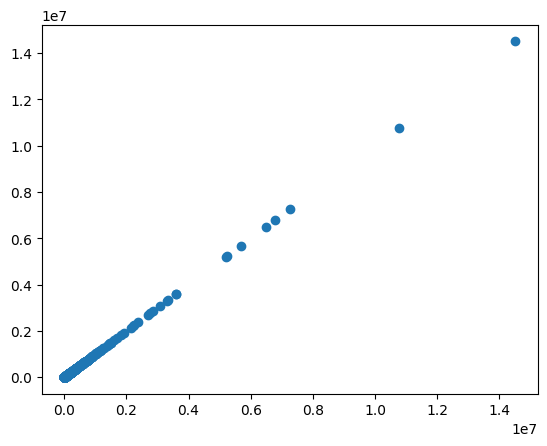

correlation between both processings: 1.0


In [33]:

input_file = os.path.join(tabledir, "spectronaut.tsv")
samplemap_file = os.path.join(tabledir, "samplemap.spectronaut.tsv")


input_data = quant_reader.import_data(input_file)
samplemap_df = quant_reader.load_samplemap(samplemap_file)
input_processed, samplemap_df_processed = quant_reader.prepare_loaded_tables(input_data, samplemap_df)
compare_generic_table_with_original(input_processed, input_file, quant_reader.INTABLE_CONFIG, "spectronaut_precursor_v2")